In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/abir_try_SVR_conv


## Convolution 2-D network 

Written by Abirlal Metya, Panini Dasgupta, Manmeet Singh (16/01/2020)

import modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.models import Sequential
from keras.layers import Dropout,LSTM,Dense,GRU
from keras.layers import LeakyReLU


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import hilbert_data1_jgrjd_20CRV3


Using TensorFlow backend.


In [3]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/abir_try_SVR_conv


### Test and Train Splitter:

#### RMM1

In [4]:
x_train,y_train,_ = hilbert_data1_jgrjd_20CRV3.data_hilbert(datetime.datetime(1979,1,1),datetime.datetime(2008,12,31))
x_test,y_test,_ = hilbert_data1_jgrjd_20CRV3.data_hilbert(datetime.datetime(1974,6,1),datetime.datetime(1978,3,16))
x_test2,y_test2,_ = hilbert_data1_jgrjd_20CRV3.data_hilbert(datetime.datetime(2009,1,1),datetime.datetime(2015,12,31))


#### RMM2

In [5]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,x_test2.shape,y_test2.shape)
y_train.head()

(10839, 24) (10839, 1) (1266, 24) (1266, 1) (2437, 24) (2437, 1)


,rmm1
date,
1979-04-30,-0.823292
1979-05-01,-0.412913
1979-05-02,0.021600
1979-05-03,0.424877
1979-05-04,0.745713


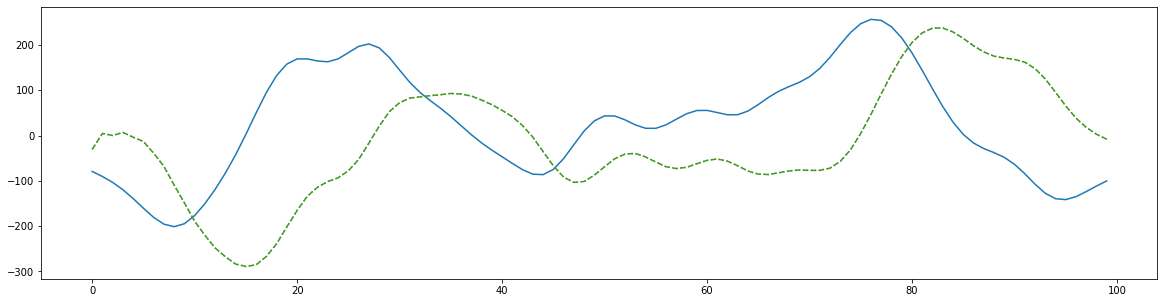

In [6]:
import matplotlib.pyplot as plt#plot the first image in the dataset
from scipy.signal import hilbert
plt.figure(figsize=[20,5])
plt.plot(np.arange(100),x_train.iloc[0:100,0],'-')
plt.plot(np.arange(100),np.imag(hilbert(x_train.iloc[:,0])[0:100]),':')
plt.plot(np.arange(100),x_train.iloc[0:100,12],'--')

#### Historical pressure

In [7]:
x_test3 = hilbert_data1_jgrjd_20CRV3.data_pres(datetime.datetime(1905,1,1),datetime.datetime(2015,12,31))
x_test3.shape

(40423, 24)

/home/cccr/supriyo/.conda/envs/knp_ai/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'RMM2')

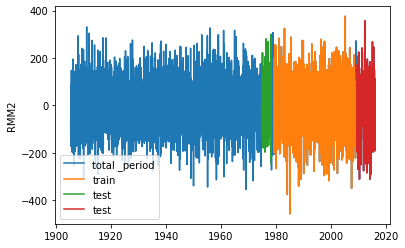

In [8]:
plt.plot(x_test3.iloc[:,0],label = 'total _period')
plt.plot(x_train.iloc[:,0], label = 'train')
plt.plot(x_test.iloc[:,0], label = 'test')
plt.plot(x_test2.iloc[:,0], label = 'test')

plt.legend()
plt.ylabel('RMM2')

#### scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc3 = MinMaxScaler()
sc5 = MinMaxScaler()

sc5.fit(x_test3[:])

test_x3 =  sc5.transform(x_test3[:])
train_x = sc5.transform(x_train[:])
test_x  = sc5.transform(x_test[:])
test_x2  = sc5.transform(x_test2[:])


sc3.fit(y_train[:])

train_y = sc3.transform(y_train)
test_y  = sc3.transform(y_test)
test_y2  = sc3.transform(y_test2)

train_x.max(),test_x.max(),test_x3.max(),test_x2.max(),train_y.max(),test_y.max(),test_y2.max()

(1.0002254305406701,
 1.0000000004960428,
 1.0000000000000002,
 0.995020089895504,
 1.0,
 0.7624026824587242,
 0.8094679826583451)

In RNN we have to choose a window. Here we choose first 120 points as predictor and next RMM value as predicted. That means RMM will be fitted using previous 120 time steps's pressure of every point

#### split the sequence data for training

In [10]:
def split_sequence(window,x,*args):
    xout  = []
    for i in range(window,len(x)):
        xout.append(x[i-window:i,:])
    
    xout = np.array(xout)
    xout = np.reshape(xout,(xout.shape[0],xout.shape[1],xout.shape[2]))
        
    if np.any(len(args)):
        for y in args:
            yout = []
            for i in range(window,len(y)):
                yout.append(y[i,0])
            yout = np.array(yout)
            yout = yout.reshape(yout.shape[0])
    else:
        yout = [] 
    
    return xout,yout

In [11]:
window = 120
xtrain , ytrain = split_sequence(window,train_x,train_y)
xtest , ytest = split_sequence(window,test_x,test_y)
xtest2 , ytest2 = split_sequence(window,test_x2,test_y2)
xtest3,_ = split_sequence(window, test_x3)

#### Cut the data according to batch size

In [12]:
par_b =100 

print(x_test3.shape)
te3_lc = ((len(x_test3)-window)//par_b)*par_b

xtest3 = xtest3[:te3_lc,:,:]
print(xtest3.shape)

x_test3.iloc[window:window+te3_lc,:].index
## THis perid data will be available



(40423, 24)
(40300, 120, 24)


DatetimeIndex(['1905-08-28', '1905-08-29', '1905-08-30', '1905-08-31',
               '1905-09-01', '1905-09-02', '1905-09-03', '1905-09-04',
               '1905-09-05', '1905-09-06',
               ...
               '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22',
               '2015-12-23', '2015-12-24', '2015-12-25', '2015-12-26',
               '2015-12-27', '2015-12-28'],
              dtype='datetime64[ns]', name='Datetime', length=40300, freq=None)

In [13]:
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

tr_lc = ((len(x_train)-window)//par_b)*par_b
te_lc =  ((len(x_test)-window)//par_b)*par_b
te_lc2 =  ((len(x_test2)-window)//par_b)*par_b

xtrain = xtrain[:tr_lc,:,:]
ytrain = ytrain[:tr_lc]
xtest = xtest[:te_lc,:,:]
ytest = ytest[:te_lc,]
xtest2 = xtest2[:te_lc2,:,:]
ytest2 = ytest2[:te_lc2,]
print(xtrain.shape,ytrain.shape,xtest.shape,xtest2.shape,ytest.shape,ytest2.shape)

(10719, 120, 24) (10719,) (1146, 120, 24) (1146,)
(10700, 120, 24) (10700,) (1100, 120, 24) (2300, 120, 24) (1100,) (2300,)


### Using Simple Convolution 1D
* 1. Basic conv1d
* 2. wavenet
* 3. ENSO  paper model


In [135]:
## RMM2 abir batch

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten,MaxPooling1D,Dropout, Activation, Flatten
from keras.layers import BatchNormalization

model = Sequential()
# Use the Keras Conv1D function to create a 1-dimensional convolutional layer, with kernel size (filter) of 5X5 pixels and a stride of 1 in x and y directions. The Conv2D command automatically creates the activation function for you━here we use ReLu activation.
model.add(Conv1D(48 ,kernel_size=8, strides=1,
                 activation='relu',
                 input_shape=(xtrain.shape[1],xtrain.shape[2])))
#model.add(BatchNormalization())
# Then use the MaxPooling2D function to add a 2D max pooling layer, with pooling filter sized 2X2 and stride of 2 in x and y directions.
model.add(MaxPooling1D(pool_size=1, strides=1))
model.add(Conv1D(32, kernel_size=4, strides=1,
                 activation='relu'))
# Then use the MaxPooling2D function to add a 2D max pooling layer, with pooling filter sized 2X2 and stride of 2 in x and y directions.
#model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1, strides=1))
model.add(Conv1D(8, kernel_size=2, strides=1,
                 activation='relu'))

model.add(Flatten())
model.add(Dense(20, activation='relu'))
#model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1000, activation='relu'))
# model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
opt = keras.optimizers.Adam(learning_rate=0.005, decay=1e-6)
model.compile(loss='mae', optimizer=opt)


In [136]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 113, 48)           9264      
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 113, 48)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 110, 32)           6176      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 110, 32)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 109, 8)            520       
_________________________________________________________________
flatten_15 (Flatten)         (None, 872)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)              

In [142]:
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest),batch_size=100, epochs=10)

Train on 10700 samples, validate on 1100 samples
Epoch 1/10
10700/10700 [==============================] - 1s 86us/step - loss: 0.0515 - val_loss: 0.0549
Epoch 2/10
10700/10700 [==============================] - 1s 79us/step - loss: 0.0516 - val_loss: 0.0539
Epoch 3/10
10700/10700 [==============================] - 1s 77us/step - loss: 0.0516 - val_loss: 0.0502
Epoch 4/10
10700/10700 [==============================] - 1s 81us/step - loss: 0.0509 - val_loss: 0.0533
Epoch 5/10
10700/10700 [==============================] - 1s 75us/step - loss: 0.0509 - val_loss: 0.0523
Epoch 6/10
10700/10700 [==============================] - 1s 75us/step - loss: 0.0508 - val_loss: 0.0508
Epoch 7/10
10700/10700 [==============================] - 1s 75us/step - loss: 0.0517 - val_loss: 0.0523
Epoch 8/10
10700/10700 [==============================] - 1s 74us/step - loss: 0.0509 - val_loss: 0.0513
Epoch 9/10
10700/10700 [==============================] - 1s 75us/step - loss: 0.0510 - val_loss: 0.0497
Epoch 

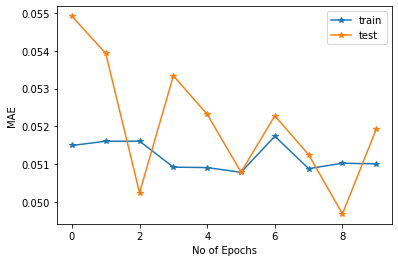

In [143]:
plt.plot(model.history.history['loss'],'-*',label ='train')
plt.plot(model.history.history['val_loss'],'-*',label ='test')
plt.ylabel('MAE')
plt.xlabel('No of Epochs')
plt.legend()

##### Predict train dataset:

training shape = 
(10700, 1)


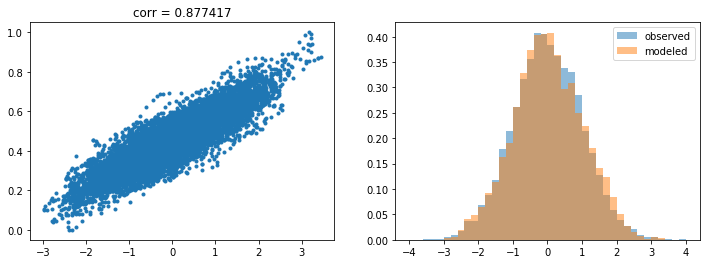

In [144]:
predict1   = model.predict(xtrain)
yy_train   = sc3.inverse_transform(predict1)
yy_train   = yy_train/yy_train.std()
train_corr = np.corrcoef(yy_train[:,0],ytrain)[0,1]

print("training shape = ");print(predict1.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_train[:,0],ytrain,'.')

ax[0].set_title('corr = %f'%train_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_train.rmm1,bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_train,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

##### Predict test dataset:

test shape = 
(2300, 1)


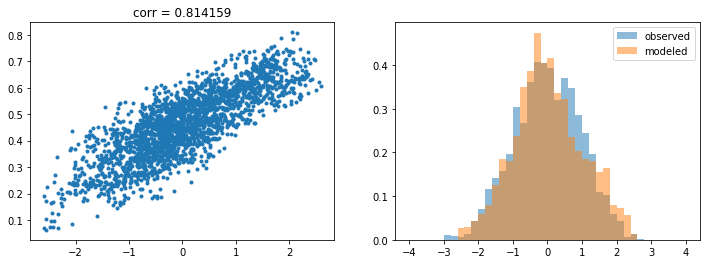

In [145]:
predict2  = model.predict(xtest2)
yy_test   = sc3.inverse_transform(predict2)
yy_test   = yy_test/yy_test.std()
test_corr = np.corrcoef(yy_test[:,0],ytest2)[0,1]

print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test[:,0],ytest2,'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test2.rmm1,bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

test shape = 
(1100, 1)


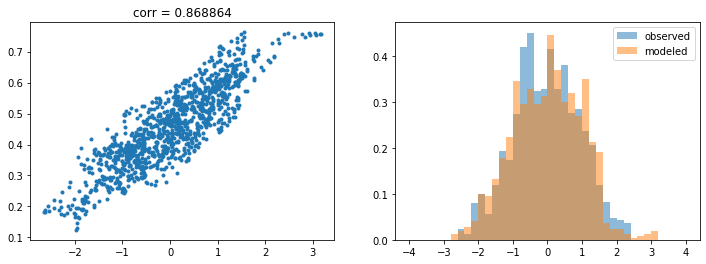

In [146]:
predict2  = model.predict(xtest)
yy_test   = sc3.inverse_transform(predict2)
yy_test   = yy_test/yy_test.std()
test_corr = np.corrcoef(yy_test[:,0],ytest)[0,1]

print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test[:,0],ytest,'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test.rmm1,bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

#### Prediction over long time period (1946-2008)

Check corelation of observed rmm2 and model prediction over 1979-2008 while using pressure from 1946-2008 